## File : Exercise 13-1_Edris_Safari.ipynb
## Name:Edris Safari
## Date:2/22/2019
## Course: DSC530 - Data Exploration and Analysis
## Desc: Week11 exercise 13-1 assignment


In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months. 
* Compute the duration of marriages that have ended in divorce
* Compute the duration, so far, of marriages that are ongoing
* Estimate the hazard and survival function for the duration of marriage
* Use resampling to take into account sampling weights
* plot data from several resamples to visualize sampling error. 

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [72]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import thinkstats2
import thinkplot
import survival

Get respondants for cycles 6 and 7

In [73]:
resp_cycle_6 = survival.ReadFemResp2002()
resp_cycle_7 = survival.ReadFemResp2010()

In [74]:
resp_cycle_6.head()

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,finalwgt,cmintvw,agemarry,age,year,decade,fives
0,2298,902,False,NaN,NaN,4,5556.717241,1234,NaN,27.666667,75,7,15
1,5012,718,True,974.0,1077.0,1,4744.191350,1233,21.333333,42.916667,59,5,11
2,11586,708,True,910.0,938.0,1,4744.191350,1234,16.833333,43.833333,58,5,11
3,6794,1042,False,NaN,NaN,0,5923.977368,1234,NaN,16.000000,86,8,17
4,616,991,False,NaN,NaN,0,7229.128072,1233,NaN,20.166667,82,8,16


In [75]:
resp_cycle_7.head()

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,wgtq1q16,cmintvw,finalwgt,agemarry,age,year,decade,fives
0,34156,799,False,NaN,NaN,0,2571.376599,1323,2571.376599,NaN,43.666667,66,6,13
1,40081,925,True,1314.0,NaN,0,11716.317848,1323,11716.317848,32.416667,33.166667,77,7,15
2,32817,958,False,NaN,NaN,0,6794.156444,1287,6794.156444,NaN,27.416667,79,7,15
3,39968,869,False,NaN,NaN,0,5469.435481,1323,5469.435481,NaN,37.833333,72,7,14
4,27121,1004,False,NaN,NaN,0,6544.538107,1285,6544.538107,NaN,23.416667,83,8,16


In [76]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    # remove invalid values of cmdivorcx 
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    # Not divorces respondats have no divorce date.
    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    # Duration of marrigae from date of marriage to date of divorce
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    # Duration of ongoing marriages
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0
    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    # Record the decade of respondents' birth
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10
    

* Compute the duration of marriages that have ended in divorce
* Compute the duration, so far, of marriages that are ongoing

In [77]:
# CleanData computes the parameters in 'duration' and 'durationsofar', and 'decade' to 
# record the decade of birth
CleanData(resp_cycle_6)
# get  married respondents
married_cycle_6 = resp_cycle_6[resp_cycle_6.evrmarry==1]

CleanData(resp_cycle_7)
married_cycle_7 = resp_cycle_7[resp_cycle_7.evrmarry==1]

* Estimate the hazard and survival function for the duration of marriage

In [78]:
for resp in [married_cycle_6,married_cycle_7]:
    complete_marriages = resp[resp.notdivorced == 0].duration.dropna()
    ongoing_marriages = resp[resp.notdivorced == 1].durationsofar.dropna()
    # Hazard function
    hf = survival.EstimateHazardFunction(complete_marriages, ongoing_marriages)
    # survival function
    sf = hf.MakeSurvival()

In [79]:
def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [80]:
def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

* Use resampling to take into account sampling weights
* plot data from several resamples to visualize sampling error. 

In [81]:
# Resample 50 times by weights
def Resample(resps,samplesize,groupby):
    for i in range(samplesize):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                    for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        # create groups
        groups = sample.groupby(groupby)

        # add label for the plot
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel='Years',
                         ylabel='Fraction undivorced',
                         axis=[0, 28, 0, 1])
            
            


Increasing the samling size makes the sampling error more visible. This makes sense because more samples provide more data from each group. 

c:\users\safar\documents\github\thinkstats2\venv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


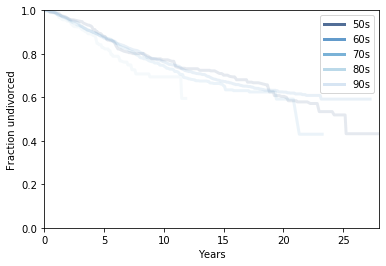

In [82]:
Resample([married_cycle_6,married_cycle_7],1,'decade')

c:\users\safar\documents\github\thinkstats2\venv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


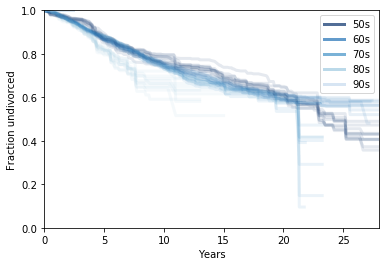

In [83]:
Resample([married_cycle_6,married_cycle_7],10,'decade')

c:\users\safar\documents\github\thinkstats2\venv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


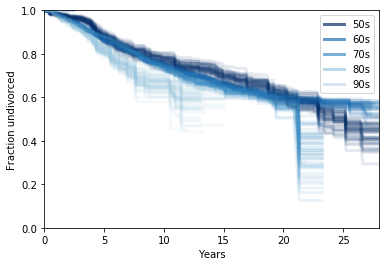

In [84]:
Resample([married_cycle_6,married_cycle_7],50,'decade')

c:\users\safar\documents\github\thinkstats2\venv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


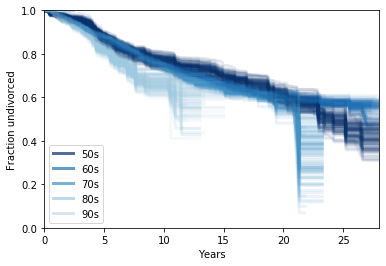

In [85]:
Resample([married_cycle_6,married_cycle_7],100,'decade')